In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tellurium as te 
from collections import OrderedDict


## Figure Idea 1
- Establish that infection has oscilating behavior, if no medication given
- Establish that erythropoesis works by resuce if 10% reduction of erythrocytes
- medication kills infection

In [19]:
def simulate_model(model_path: str = '/home/nexia/PhD/pth_model/LCT_model/LCT_OIE.ant', infection_pars: dict = {}, 
                   ss_duration:float=4.,pre_t:float=3.0, simulation_end:float=50.0, bool_med= True, 
                   selections:list=['time', '[R]', '[iE]', '[E]','[M]','[P]', 'oiE', 'Hkt',
                                     'Hb', 'LDH', 'parasitemia', 'RPI', 'J_oiE_death',
                                     'J_P_birth', 'J_P_death',
                                     'k_E_death','rpi_step_func'] + [f'[oiE_{i}]' for i in range(1, 13)]):
    """Simulates model for given BH_max value and returns dataframe with results. 
    Includes presimulation for specific time (infection_after)."""
    model = te.loada(model_path)

    # ss simulatiom
    model.M = 0
    model.events_medication_on = False 
    ss_res = model.simulate(-ss_duration-pre_t, -pre_t, 10, selections=selections)
    ss_res_df = pd.DataFrame(ss_res, columns=ss_res.colnames)    

    # infection simulation
    model.M = 40e3

    for p in infection_pars:
        model.setValue(p, infection_pars[p])

    # ACT addition
    model.events_medication_on = bool_med
    act_res = model.simulate(-pre_t, simulation_end, 501, selections=selections) #int(simulation_end+pre_t)*10
    act_res_df = pd.DataFrame(act_res, columns=act_res.colnames) 

    # combine results
    res_df = pd.concat([ss_res_df, act_res_df], axis=0)    
    return res_df 

def pretty_plot(results, axs=None):
    species_to_analyze = OrderedDict({
        'parasitemia' : ['parasitemia (%)', 1],
        '[M]' : ['M (1e4/µl)', 1e4],
        '[iE]': ['iE (1e4/µl)', 1e4],
        'oiE': ['oiE (1e4/µl)', 1e4],
        '[E]': ['E (1e6/µl)', 1e6],
        '[R]': ['R (1e4/µl)', 1e4],
        '[P]': ['P (1e2/µl)', 1e0],
        'J_P_birth':['J_P_birth',1e0],
        'Hb': ['Hb (g/dl)', 1],
        'Hkt': ['Hkt', 1],
        'RPI': ['RPI', 1],
        'LDH': ['LDH (U/l)',1],
    })
    if axs.dtype==None:
        # Durchführung des Parameter-Scans und Erstellung der Plots
        cols = 3
        rows = int(np.ceil(len(species_to_analyze)/cols))   

        fig, axs = plt.subplots(rows,cols, figsize=(20,15))
        fig.subplots_adjust(hspace=0.38, wspace= 0.42)
        size_of_font = 24

    # Farbübergang
    cmap = plt.colormaps.get_cmap('Reds')

    for j, specie in enumerate (species_to_analyze.keys()):

        row = j //3
        col = j % 3


        axs[row, col].plot(results['time'], results[specie]/species_to_analyze[specie][1],
                            color=cmap(.8))
        axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
        axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
        axs[row, col].tick_params(labelsize=size_of_font)

        axs[row, col].axvspan(0, 0.3, facecolor='gainsboro', alpha=1, linewidth=2) #, label='ACT Administration')
        axs[row, col].axvspan(1, 1.3, facecolor='gainsboro', alpha=1, linewidth=2)
        axs[row, col].axvspan(2, 2.3, facecolor='gainsboro', alpha=1, linewidth=2)

        axs[row, col].axvline(-pre_t, color='navy', alpha=1, linewidth=2, linestyle=(0, (3, 5, 1, 5)))   
        
        
    handles, labels = axs[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots


    axs[-1, -1].legend(handles, labels, loc='lower left', 
                        bbox_to_anchor=(1.05, 0.7),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)


    #plt.savefig("./figures/paramscan_BHmax_short.pdf", format="pdf",bbox_inches='tight')
    #plt.show()
    return None

In [3]:
k_infect = 1.81945778699078967e-06
k_iE_pit_frac = 0.5
# simulate no by-stander haemolysis
infect_pars = {'k_E_infect': k_infect, 's_BH': 0, 'k_iE_pit_frac': k_iE_pit_frac}
no_bh_res = simulate_model(infection_pars=infect_pars)

# simulate by-stander haemolysis
infect_pars = {'k_E_infect': k_infect, 's_BH': 1.361151210723645e-06,'k_iE_pit_frac': k_iE_pit_frac}#{'k_E_infect': k_infect, 's_BH': 1e-6 }
bh_res = simulate_model(infection_pars=infect_pars) 

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-3.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-7.0, -3.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-3.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-7.0, -3.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 



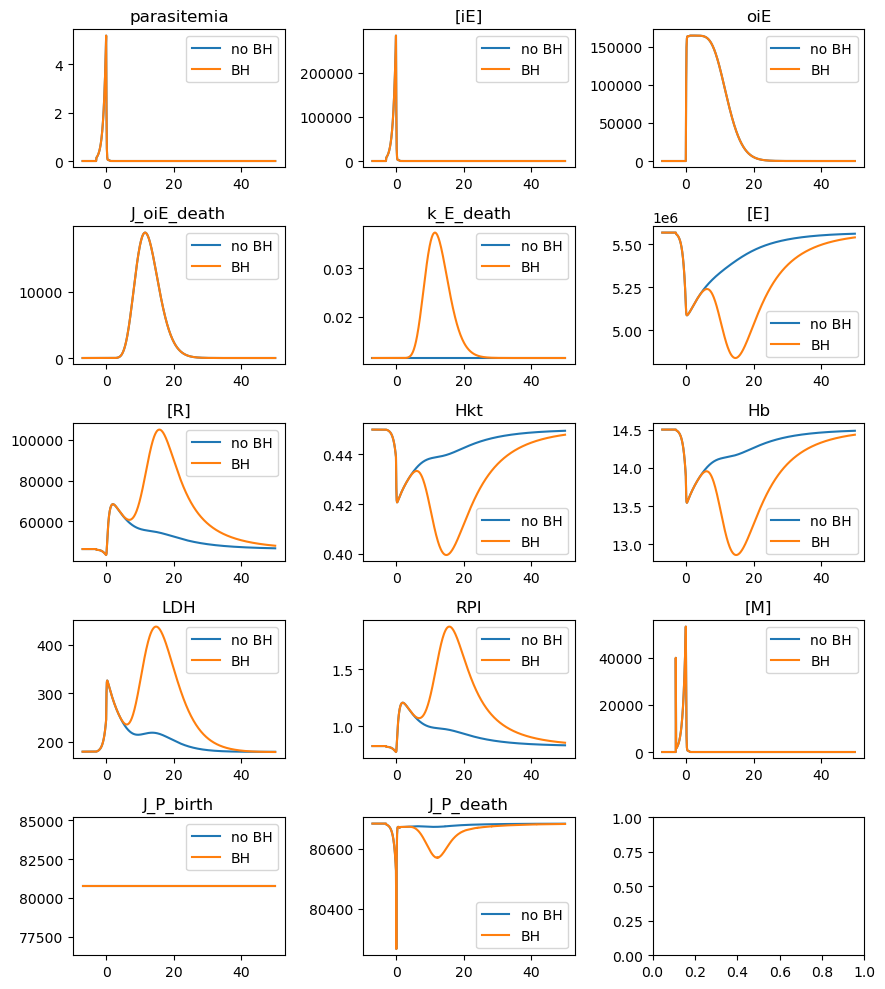

In [4]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[M]','J_P_birth', 'J_P_death']
# 'rpi_step_func'
n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    ax[row, col].plot(no_bh_res['time'], no_bh_res[obs], label='no BH')
    ax[row, col].plot(bh_res['time'], bh_res[obs], label='BH')
    ax[row, col].set_title(obs)
    ax[row, col].legend()

plt.tight_layout()  
plt.show()

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-3.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-7.0, -3.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-3.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-7.0, -3.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 



AttributeError: 'numpy.ndarray' object has no attribute 'dType'

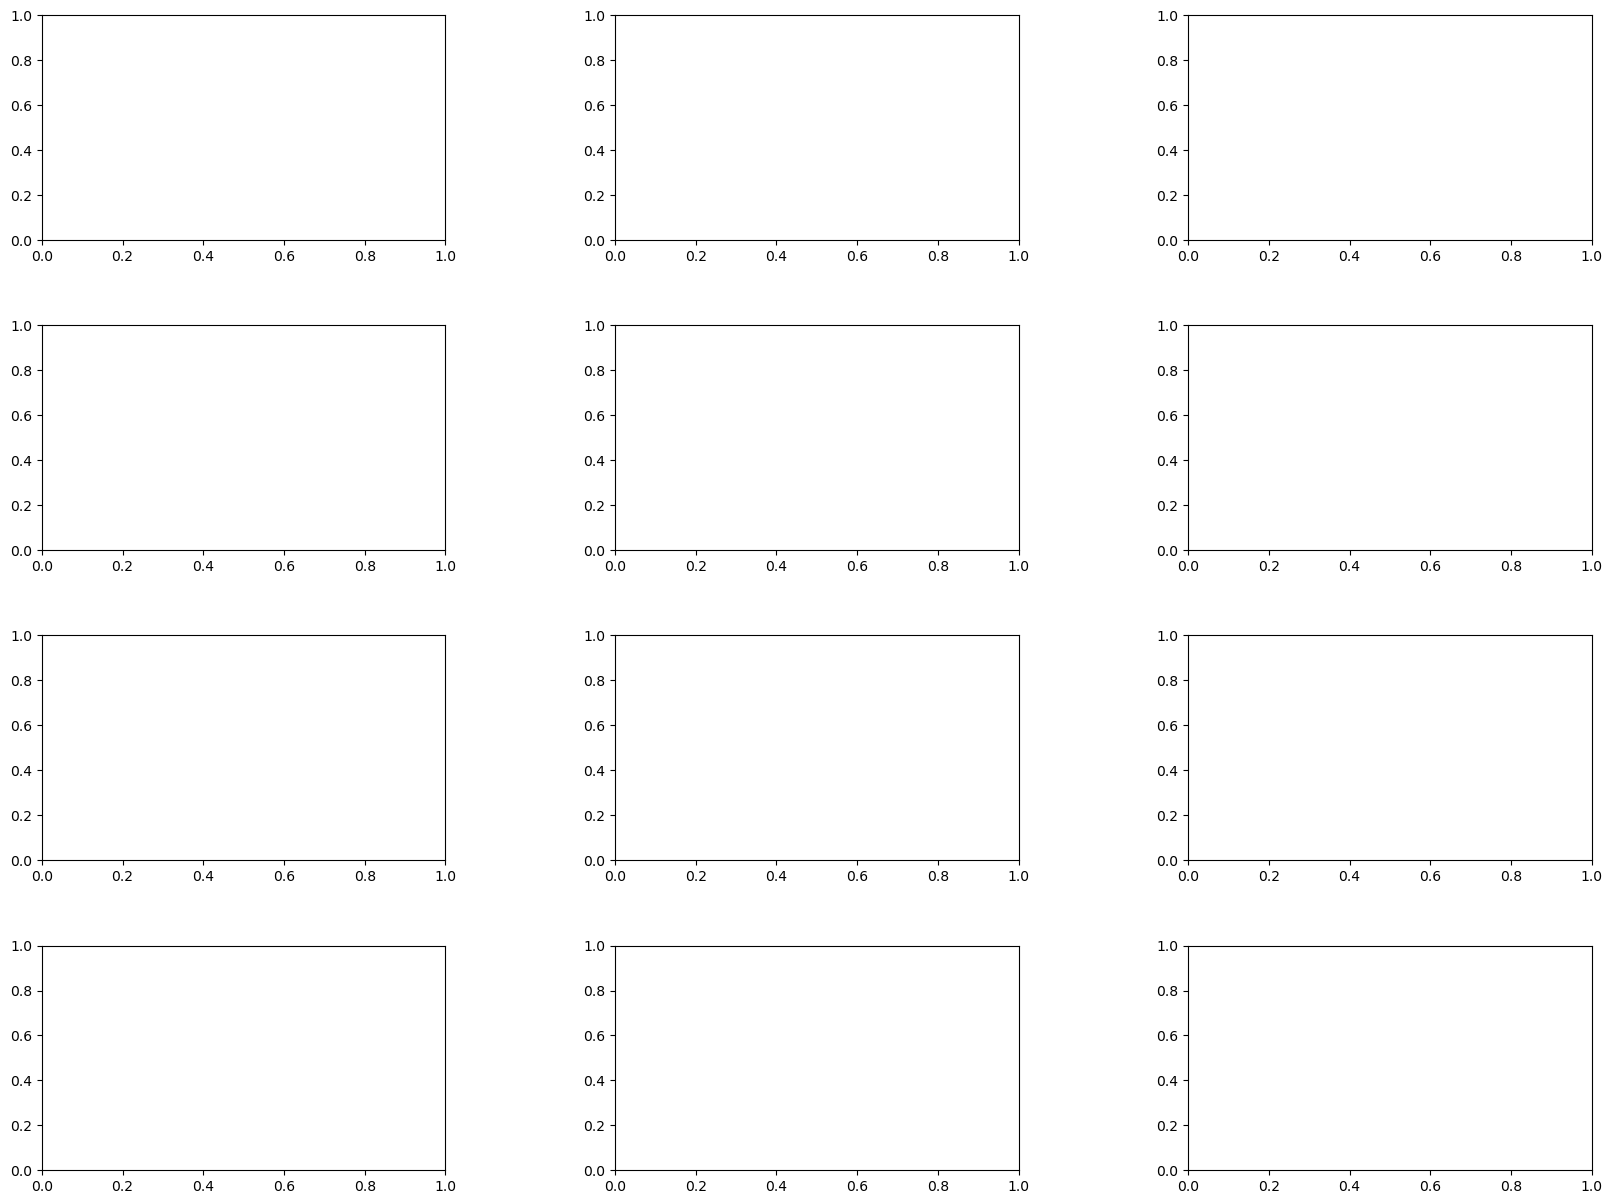

In [20]:
k_iE_pit_frac = 0.3

# simulate no by-stander haemolysis
update_parameters= {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 2.022041851367283e-06,
        "tropism": 4.429542038768788,
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "s_BH": 9.999999922941987e-09,
        "LDH": 197.37366622040253
}
infect_pars = update_parameters
pre_t = 3.0

no_meds = simulate_model(infection_pars=infect_pars, bool_med=False, simulation_end= 500)

cols = 3
rows = 4  
fig, axs_all = plt.subplots(rows,cols, figsize=(20,15))
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24

for k in range(20,90, 10):
    update_parameters= {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": k,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 2.022041851367283e-06,
        "tropism": 4.429542038768788,
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "s_BH": 9.999999922941987e-09,
        "LDH": 197.37366622040253
}
    no_meds = simulate_model(infection_pars=infect_pars, bool_med=False, simulation_end= 500)

    pretty_plot(no_meds, axs_all)
fig.show()